In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
import os

In [ ]:
# !unzip /content/drive/MyDrive/SAR/classification.zip

In [ ]:
DATA_DIR = os.path.join('/', 'content', 'v_2')
BATCH_SIZE = 32
EPOCHS = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)
data = data.map(lambda images, labels: (images/255, labels))

Found 16000 files belonging to 4 classes.


In [ ]:
class_names = os.listdir(DATA_DIR)
n_classes = len(class_names)

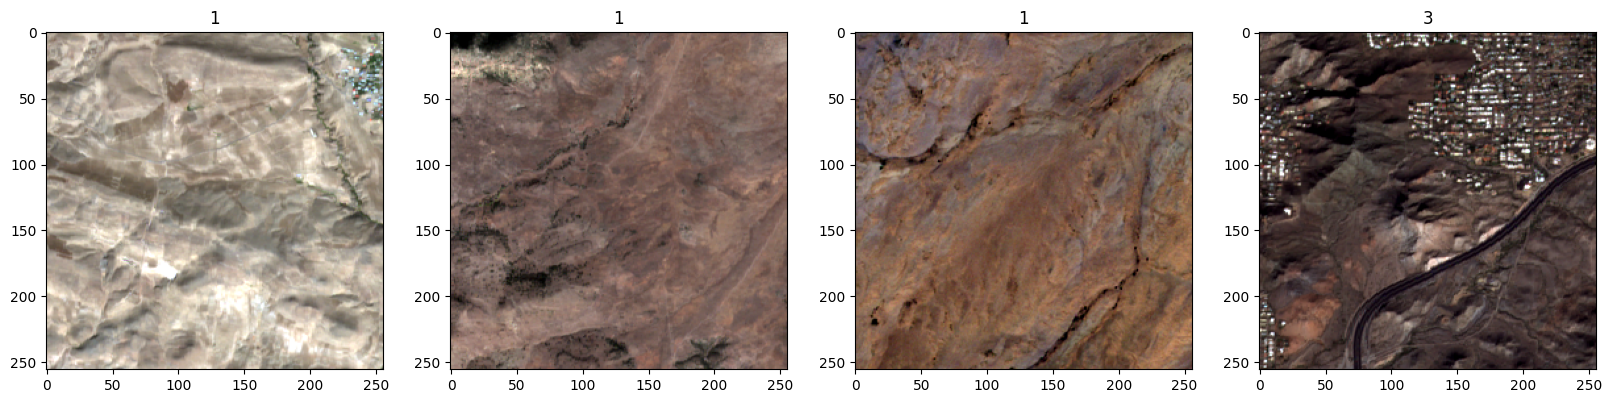

In [ ]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes)
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,412,836 (32.09 MB)

 Trainable params: 8,412,836 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
  train,
  validation_data=validation,
  epochs=EPOCHS
)

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 60s 164ms/step - accuracy: 0.7518 - loss: 0.6212 - val_accuracy: 0.9579 - val_loss: 0.1396
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.9551 - loss: 0.1330 - val_accuracy: 0.9412 - val_loss: 0.1687
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.9727 - loss: 0.0834 - val_accuracy: 0.9694 - val_loss: 0.0892
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - accuracy: 0.9822 - loss: 0.0544 - val_accuracy: 0.9697 - val_loss: 0.0942
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.9938 - loss: 0.0218 - val_accuracy: 0.9644 - val_loss: 0.1152
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 158ms/step - accuracy: 0.9865 - loss: 0.0396 - val_accuracy: 0.9660 - val_loss: 0.1054
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - accuracy: 0.9967 - loss: 0.0136 - val_accuracy: 0.9780 - val_loss: 0.0808
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.9965 - loss: 0

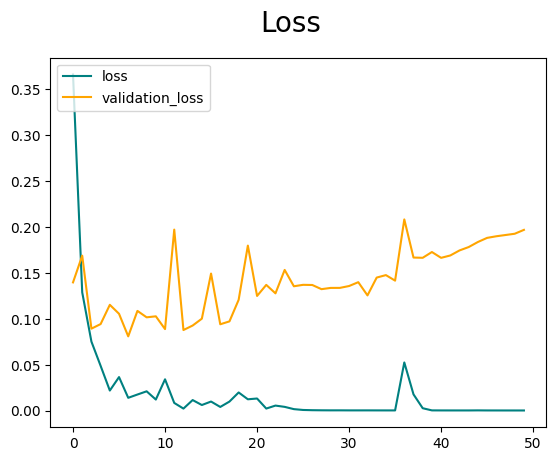

In [ ]:
# loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

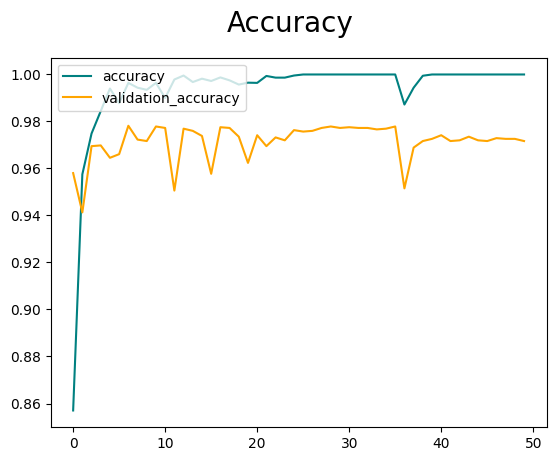

In [ ]:
# accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'],
         color='orange', label='validation_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.evaluate(test, batch_size=BATCH_SIZE)

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.9676 - loss: 0.2349


[0.20805183053016663, 0.9713010191917419]

In [ ]:
model.save('/content/drive/MyDrive/SAR/classification.keras')